# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

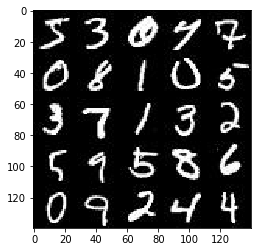

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

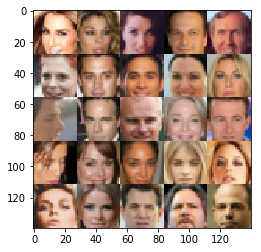

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [29]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.2
    
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',activation=None)
        relu1 = tf.maximum(alpha * x1, x1)
        #print(relu1.get_shape().as_list())
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',activation=None)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',activation=None)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #print(relu3.get_shape().as_list())
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        #print(flat.get_shape().as_list())
        logits = tf.layers.dense(flat, 1,activation=None)
        out = tf.sigmoid(logits)
        out = tf.nn.dropout(out, keep_prob=0.5)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [45]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    not_training = not is_train
       
    with tf.variable_scope('generator',reuse=not_training):
        #First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512,activation=None)
        #Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1.get_shape().as_list())
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 2, strides=2, padding='same',activation=None)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.get_shape().as_list())
        
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',activation=None)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        #print(x3.get_shape().as_list())
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same',activation=None)
        #print(logits.get_shape().as_list())
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [46]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [47]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [48]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [49]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    #print the losses every 10 batches
    print_every = 10
    
    #show the generator output every 100 batches
    show_every = 100
    
    #number of images we want the show_generator function to produce
    n_images = 25
    
    #need image_width, image_height,image_channels for model inputs
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    out_channel_dim = data_shape[3]
    
    
    #now get the model inputs
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    #build the GANs for training and calculate the loss
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    
    #run the optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    losses = []
    steps = 0
    
    
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                #Normalize the batch images beacuse they are -0.5 to 0.5
                normed_batch_images = batch_images * 2
                
                #Sample random noise for the Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: normed_batch_images,
                                              input_z: batch_z,
                                              lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: normed_batch_images,
                                              input_z: batch_z,
                                              lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: normed_batch_images,
                                              input_z: batch_z,
                                              lr:learning_rate})
                
                if steps % print_every == 0:
                    #At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: normed_batch_images,
                                              input_z: batch_z,
                                              lr:learning_rate})
                    train_loss_g = g_loss.eval({input_real: normed_batch_images,
                                              input_z: batch_z,
                                              lr:learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    #Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)
                                  
    return losses            
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.1652... Generator Loss: 10.5445
Epoch 1/2... Discriminator Loss: 1.9351... Generator Loss: 10.9690
Epoch 1/2... Discriminator Loss: 2.4772... Generator Loss: 4.0474
Epoch 1/2... Discriminator Loss: 2.3163... Generator Loss: 1.8225
Epoch 1/2... Discriminator Loss: 1.9373... Generator Loss: 0.4561
Epoch 1/2... Discriminator Loss: 1.7583... Generator Loss: 0.6615
Epoch 1/2... Discriminator Loss: 1.6572... Generator Loss: 1.0196
Epoch 1/2... Discriminator Loss: 1.3134... Generator Loss: 0.8187
Epoch 1/2... Discriminator Loss: 1.5133... Generator Loss: 0.8360
Epoch 1/2... Discriminator Loss: 1.3850... Generator Loss: 1.0466


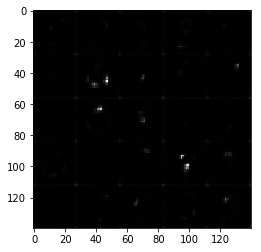

Epoch 1/2... Discriminator Loss: 1.4030... Generator Loss: 1.2286
Epoch 1/2... Discriminator Loss: 1.3671... Generator Loss: 0.9167
Epoch 1/2... Discriminator Loss: 1.2644... Generator Loss: 1.0397
Epoch 1/2... Discriminator Loss: 1.5418... Generator Loss: 1.2633
Epoch 1/2... Discriminator Loss: 1.1671... Generator Loss: 1.5800
Epoch 1/2... Discriminator Loss: 1.4271... Generator Loss: 2.0758
Epoch 1/2... Discriminator Loss: 1.4617... Generator Loss: 1.0508
Epoch 1/2... Discriminator Loss: 1.7592... Generator Loss: 0.6447
Epoch 1/2... Discriminator Loss: 1.9447... Generator Loss: 0.2887
Epoch 1/2... Discriminator Loss: 1.9895... Generator Loss: 1.3138


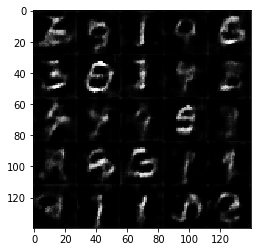

Epoch 1/2... Discriminator Loss: 1.5144... Generator Loss: 0.8754
Epoch 1/2... Discriminator Loss: 1.7198... Generator Loss: 0.3886
Epoch 1/2... Discriminator Loss: 1.7717... Generator Loss: 0.3473
Epoch 1/2... Discriminator Loss: 1.8533... Generator Loss: 0.3075
Epoch 1/2... Discriminator Loss: 1.6470... Generator Loss: 0.4036
Epoch 1/2... Discriminator Loss: 1.5051... Generator Loss: 0.5559
Epoch 1/2... Discriminator Loss: 1.5676... Generator Loss: 0.4732
Epoch 1/2... Discriminator Loss: 1.5867... Generator Loss: 1.0434
Epoch 1/2... Discriminator Loss: 1.5033... Generator Loss: 0.7785
Epoch 1/2... Discriminator Loss: 1.5253... Generator Loss: 0.6298


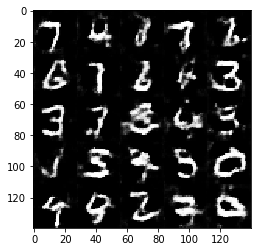

Epoch 1/2... Discriminator Loss: 1.5671... Generator Loss: 0.8781
Epoch 1/2... Discriminator Loss: 1.7505... Generator Loss: 0.3447
Epoch 1/2... Discriminator Loss: 1.6366... Generator Loss: 0.3862
Epoch 1/2... Discriminator Loss: 1.5045... Generator Loss: 0.5028
Epoch 1/2... Discriminator Loss: 1.8047... Generator Loss: 0.3297
Epoch 1/2... Discriminator Loss: 1.4900... Generator Loss: 0.6322
Epoch 1/2... Discriminator Loss: 1.6103... Generator Loss: 0.5648
Epoch 1/2... Discriminator Loss: 1.4832... Generator Loss: 0.7805
Epoch 1/2... Discriminator Loss: 1.7677... Generator Loss: 0.3434
Epoch 1/2... Discriminator Loss: 1.8361... Generator Loss: 0.3094


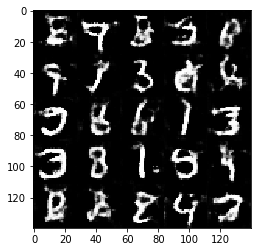

Epoch 1/2... Discriminator Loss: 1.8251... Generator Loss: 0.3000
Epoch 1/2... Discriminator Loss: 1.5693... Generator Loss: 0.5015
Epoch 1/2... Discriminator Loss: 1.7203... Generator Loss: 0.3861
Epoch 1/2... Discriminator Loss: 1.4617... Generator Loss: 1.0009
Epoch 1/2... Discriminator Loss: 1.3227... Generator Loss: 0.8606
Epoch 1/2... Discriminator Loss: 1.4659... Generator Loss: 0.6822
Epoch 1/2... Discriminator Loss: 1.6525... Generator Loss: 0.4016
Epoch 1/2... Discriminator Loss: 1.4971... Generator Loss: 1.0009
Epoch 1/2... Discriminator Loss: 1.4935... Generator Loss: 0.9745
Epoch 1/2... Discriminator Loss: 1.4417... Generator Loss: 1.0619


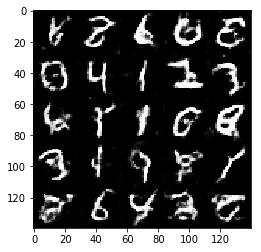

Epoch 1/2... Discriminator Loss: 1.4312... Generator Loss: 0.6980
Epoch 1/2... Discriminator Loss: 1.8972... Generator Loss: 0.2672
Epoch 1/2... Discriminator Loss: 1.3755... Generator Loss: 0.8514
Epoch 1/2... Discriminator Loss: 1.5120... Generator Loss: 0.6663
Epoch 1/2... Discriminator Loss: 1.6298... Generator Loss: 1.1659
Epoch 1/2... Discriminator Loss: 1.4808... Generator Loss: 0.5707
Epoch 1/2... Discriminator Loss: 2.0257... Generator Loss: 0.2225
Epoch 1/2... Discriminator Loss: 1.5799... Generator Loss: 0.4196
Epoch 1/2... Discriminator Loss: 1.5651... Generator Loss: 0.5121
Epoch 1/2... Discriminator Loss: 1.4336... Generator Loss: 0.5706


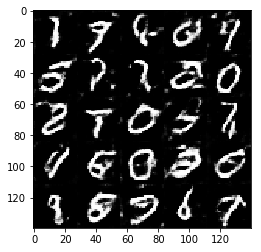

Epoch 1/2... Discriminator Loss: 1.5565... Generator Loss: 1.0067
Epoch 1/2... Discriminator Loss: 1.4131... Generator Loss: 0.6649
Epoch 1/2... Discriminator Loss: 1.4610... Generator Loss: 0.6132
Epoch 1/2... Discriminator Loss: 1.5129... Generator Loss: 0.8910
Epoch 1/2... Discriminator Loss: 1.4854... Generator Loss: 0.6057
Epoch 1/2... Discriminator Loss: 1.4322... Generator Loss: 0.8161
Epoch 1/2... Discriminator Loss: 1.4279... Generator Loss: 0.8791
Epoch 1/2... Discriminator Loss: 1.4944... Generator Loss: 1.0770
Epoch 1/2... Discriminator Loss: 1.6434... Generator Loss: 0.4520
Epoch 1/2... Discriminator Loss: 1.5891... Generator Loss: 0.3919


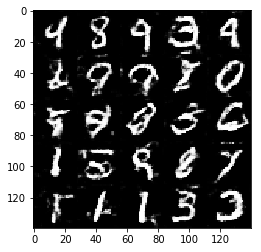

Epoch 1/2... Discriminator Loss: 1.6277... Generator Loss: 0.3912
Epoch 1/2... Discriminator Loss: 1.5571... Generator Loss: 0.8251
Epoch 1/2... Discriminator Loss: 1.7075... Generator Loss: 1.1770
Epoch 1/2... Discriminator Loss: 1.3276... Generator Loss: 1.1211
Epoch 1/2... Discriminator Loss: 1.4570... Generator Loss: 0.8150
Epoch 1/2... Discriminator Loss: 1.3389... Generator Loss: 0.7554
Epoch 1/2... Discriminator Loss: 1.1781... Generator Loss: 0.9056
Epoch 1/2... Discriminator Loss: 1.4443... Generator Loss: 0.7969
Epoch 1/2... Discriminator Loss: 1.5217... Generator Loss: 0.9178
Epoch 1/2... Discriminator Loss: 1.5812... Generator Loss: 1.2735


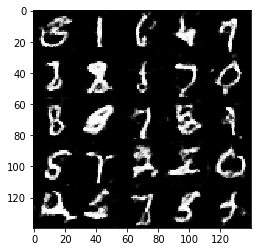

Epoch 1/2... Discriminator Loss: 1.4094... Generator Loss: 0.9004
Epoch 1/2... Discriminator Loss: 1.7279... Generator Loss: 0.3520
Epoch 1/2... Discriminator Loss: 1.6963... Generator Loss: 0.3758
Epoch 1/2... Discriminator Loss: 1.0060... Generator Loss: 1.3850
Epoch 1/2... Discriminator Loss: 1.3388... Generator Loss: 0.7162
Epoch 1/2... Discriminator Loss: 1.8452... Generator Loss: 0.2896
Epoch 1/2... Discriminator Loss: 1.5166... Generator Loss: 1.1465
Epoch 1/2... Discriminator Loss: 1.3729... Generator Loss: 1.0773
Epoch 1/2... Discriminator Loss: 1.5070... Generator Loss: 0.8788
Epoch 1/2... Discriminator Loss: 1.4697... Generator Loss: 0.6216


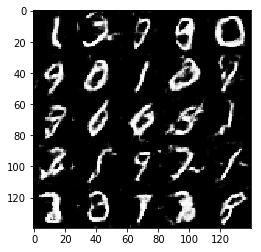

Epoch 1/2... Discriminator Loss: 1.3917... Generator Loss: 0.7090
Epoch 1/2... Discriminator Loss: 1.8114... Generator Loss: 0.2870
Epoch 1/2... Discriminator Loss: 1.3572... Generator Loss: 0.6972
Epoch 2/2... Discriminator Loss: 1.4747... Generator Loss: 0.5066
Epoch 2/2... Discriminator Loss: 1.3932... Generator Loss: 0.7101
Epoch 2/2... Discriminator Loss: 1.3245... Generator Loss: 0.8153
Epoch 2/2... Discriminator Loss: 1.5452... Generator Loss: 0.9910
Epoch 2/2... Discriminator Loss: 1.7817... Generator Loss: 1.0777
Epoch 2/2... Discriminator Loss: 1.3656... Generator Loss: 0.8305
Epoch 2/2... Discriminator Loss: 1.4505... Generator Loss: 0.6096


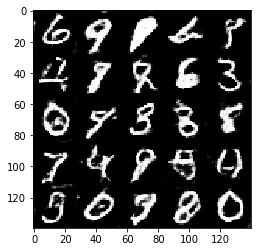

Epoch 2/2... Discriminator Loss: 1.3266... Generator Loss: 0.6815
Epoch 2/2... Discriminator Loss: 1.7700... Generator Loss: 0.3599
Epoch 2/2... Discriminator Loss: 1.7949... Generator Loss: 0.2979
Epoch 2/2... Discriminator Loss: 1.4769... Generator Loss: 0.4904
Epoch 2/2... Discriminator Loss: 1.4830... Generator Loss: 1.1747
Epoch 2/2... Discriminator Loss: 1.6273... Generator Loss: 0.3785
Epoch 2/2... Discriminator Loss: 1.6931... Generator Loss: 0.3484
Epoch 2/2... Discriminator Loss: 1.7335... Generator Loss: 0.3356
Epoch 2/2... Discriminator Loss: 1.6911... Generator Loss: 0.3453
Epoch 2/2... Discriminator Loss: 1.4990... Generator Loss: 0.4343


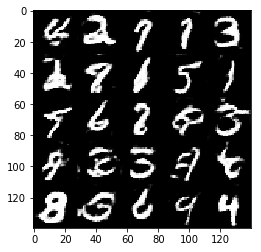

Epoch 2/2... Discriminator Loss: 1.2757... Generator Loss: 0.6921
Epoch 2/2... Discriminator Loss: 1.3286... Generator Loss: 0.6392
Epoch 2/2... Discriminator Loss: 1.4105... Generator Loss: 0.6932
Epoch 2/2... Discriminator Loss: 1.3915... Generator Loss: 1.7159
Epoch 2/2... Discriminator Loss: 1.4460... Generator Loss: 0.5972
Epoch 2/2... Discriminator Loss: 1.5736... Generator Loss: 1.1550
Epoch 2/2... Discriminator Loss: 1.6388... Generator Loss: 0.3817
Epoch 2/2... Discriminator Loss: 1.8189... Generator Loss: 0.2968
Epoch 2/2... Discriminator Loss: 1.5811... Generator Loss: 0.4031
Epoch 2/2... Discriminator Loss: 1.1823... Generator Loss: 0.7603


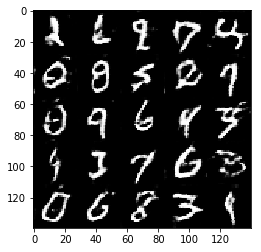

Epoch 2/2... Discriminator Loss: 1.2261... Generator Loss: 0.8718
Epoch 2/2... Discriminator Loss: 1.3101... Generator Loss: 1.3511
Epoch 2/2... Discriminator Loss: 1.5768... Generator Loss: 0.4245
Epoch 2/2... Discriminator Loss: 1.3733... Generator Loss: 0.7566
Epoch 2/2... Discriminator Loss: 1.4102... Generator Loss: 0.8014
Epoch 2/2... Discriminator Loss: 1.4008... Generator Loss: 0.7767
Epoch 2/2... Discriminator Loss: 1.4610... Generator Loss: 0.5640
Epoch 2/2... Discriminator Loss: 1.9708... Generator Loss: 0.2507
Epoch 2/2... Discriminator Loss: 1.4421... Generator Loss: 0.5313
Epoch 2/2... Discriminator Loss: 1.3907... Generator Loss: 0.6144


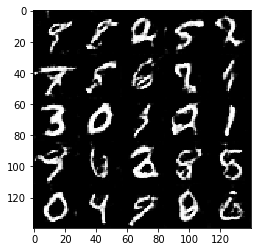

Epoch 2/2... Discriminator Loss: 1.2639... Generator Loss: 1.3517
Epoch 2/2... Discriminator Loss: 1.4674... Generator Loss: 0.9435
Epoch 2/2... Discriminator Loss: 1.5018... Generator Loss: 1.4106
Epoch 2/2... Discriminator Loss: 1.6827... Generator Loss: 0.3504
Epoch 2/2... Discriminator Loss: 2.0690... Generator Loss: 0.2393
Epoch 2/2... Discriminator Loss: 1.3459... Generator Loss: 0.8525
Epoch 2/2... Discriminator Loss: 1.4259... Generator Loss: 0.5285
Epoch 2/2... Discriminator Loss: 1.7566... Generator Loss: 0.3238
Epoch 2/2... Discriminator Loss: 1.3934... Generator Loss: 0.5315
Epoch 2/2... Discriminator Loss: 1.5931... Generator Loss: 0.3901


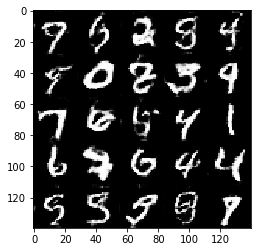

Epoch 2/2... Discriminator Loss: 2.3252... Generator Loss: 0.2274
Epoch 2/2... Discriminator Loss: 1.3004... Generator Loss: 0.7034
Epoch 2/2... Discriminator Loss: 1.4715... Generator Loss: 0.6712
Epoch 2/2... Discriminator Loss: 1.2322... Generator Loss: 0.8773
Epoch 2/2... Discriminator Loss: 1.5882... Generator Loss: 0.4137
Epoch 2/2... Discriminator Loss: 1.2770... Generator Loss: 1.0447
Epoch 2/2... Discriminator Loss: 1.2797... Generator Loss: 0.8526
Epoch 2/2... Discriminator Loss: 1.2598... Generator Loss: 1.5089
Epoch 2/2... Discriminator Loss: 1.4397... Generator Loss: 0.5662
Epoch 2/2... Discriminator Loss: 1.1796... Generator Loss: 1.4161


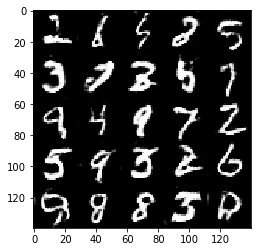

Epoch 2/2... Discriminator Loss: 1.3226... Generator Loss: 0.8993
Epoch 2/2... Discriminator Loss: 1.5301... Generator Loss: 0.4147
Epoch 2/2... Discriminator Loss: 1.1474... Generator Loss: 0.7441
Epoch 2/2... Discriminator Loss: 1.5544... Generator Loss: 1.7360
Epoch 2/2... Discriminator Loss: 1.5354... Generator Loss: 0.4254
Epoch 2/2... Discriminator Loss: 1.3418... Generator Loss: 0.7373
Epoch 2/2... Discriminator Loss: 1.4714... Generator Loss: 0.8564
Epoch 2/2... Discriminator Loss: 1.5051... Generator Loss: 1.2632
Epoch 2/2... Discriminator Loss: 1.5753... Generator Loss: 0.4972
Epoch 2/2... Discriminator Loss: 1.4645... Generator Loss: 0.5766


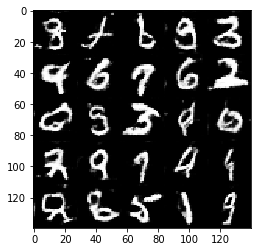

Epoch 2/2... Discriminator Loss: 1.7193... Generator Loss: 1.1843
Epoch 2/2... Discriminator Loss: 1.3109... Generator Loss: 1.1814
Epoch 2/2... Discriminator Loss: 1.3076... Generator Loss: 0.9929
Epoch 2/2... Discriminator Loss: 1.0268... Generator Loss: 1.1599
Epoch 2/2... Discriminator Loss: 1.8264... Generator Loss: 0.3083
Epoch 2/2... Discriminator Loss: 1.2153... Generator Loss: 1.0758
Epoch 2/2... Discriminator Loss: 1.3577... Generator Loss: 0.5400
Epoch 2/2... Discriminator Loss: 1.7899... Generator Loss: 0.3321
Epoch 2/2... Discriminator Loss: 1.3312... Generator Loss: 0.6878
Epoch 2/2... Discriminator Loss: 1.5338... Generator Loss: 0.4326


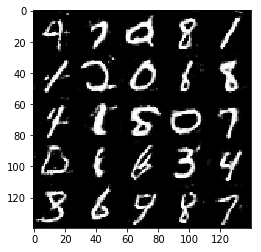

Epoch 2/2... Discriminator Loss: 1.9766... Generator Loss: 0.2492
Epoch 2/2... Discriminator Loss: 1.2452... Generator Loss: 0.6794
Epoch 2/2... Discriminator Loss: 1.4423... Generator Loss: 0.9450
Epoch 2/2... Discriminator Loss: 0.8235... Generator Loss: 1.7522
Epoch 2/2... Discriminator Loss: 1.2151... Generator Loss: 1.1158
Epoch 2/2... Discriminator Loss: 0.9415... Generator Loss: 1.9067
Epoch 2/2... Discriminator Loss: 1.7333... Generator Loss: 0.3384
Epoch 2/2... Discriminator Loss: 1.6829... Generator Loss: 0.3688
Epoch 2/2... Discriminator Loss: 0.9741... Generator Loss: 0.8788
Epoch 2/2... Discriminator Loss: 1.4580... Generator Loss: 0.6124


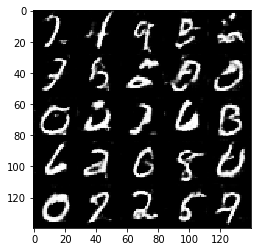

Epoch 2/2... Discriminator Loss: 1.3591... Generator Loss: 0.7098
Epoch 2/2... Discriminator Loss: 2.4345... Generator Loss: 0.1520
Epoch 2/2... Discriminator Loss: 1.5192... Generator Loss: 0.4442
Epoch 2/2... Discriminator Loss: 1.8578... Generator Loss: 0.3029
Epoch 2/2... Discriminator Loss: 1.4592... Generator Loss: 1.0636
Epoch 2/2... Discriminator Loss: 1.4659... Generator Loss: 0.5066
Epoch 2/2... Discriminator Loss: 1.6606... Generator Loss: 1.5398


In [50]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.0441... Generator Loss: 28.4997
Epoch 1/1... Discriminator Loss: 3.0452... Generator Loss: 0.1583
Epoch 1/1... Discriminator Loss: 2.3717... Generator Loss: 1.2072
Epoch 1/1... Discriminator Loss: 1.7710... Generator Loss: 1.2717
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 2.4254... Generator Loss: 0.1695
Epoch 1/1... Discriminator Loss: 1.7489... Generator Loss: 0.5555
Epoch 1/1... Discriminator Loss: 1.9141... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.6503... Generator Loss: 0.5485


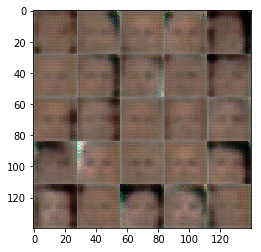

Epoch 1/1... Discriminator Loss: 1.7216... Generator Loss: 0.4834
Epoch 1/1... Discriminator Loss: 1.6873... Generator Loss: 0.5146
Epoch 1/1... Discriminator Loss: 1.7031... Generator Loss: 0.5332
Epoch 1/1... Discriminator Loss: 1.5370... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.5425... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.5674... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.5261... Generator Loss: 0.5957


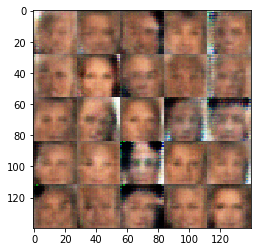

Epoch 1/1... Discriminator Loss: 1.5146... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.5780... Generator Loss: 0.5992
Epoch 1/1... Discriminator Loss: 1.5988... Generator Loss: 0.9083
Epoch 1/1... Discriminator Loss: 1.5147... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.5156... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.5424... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 1.1619


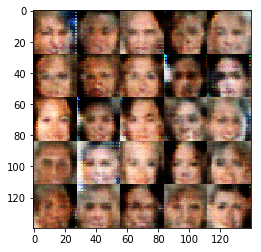

Epoch 1/1... Discriminator Loss: 1.5524... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.5761... Generator Loss: 0.5558
Epoch 1/1... Discriminator Loss: 1.5872... Generator Loss: 0.4628
Epoch 1/1... Discriminator Loss: 1.5958... Generator Loss: 0.4964
Epoch 1/1... Discriminator Loss: 1.6392... Generator Loss: 0.4388
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.9378
Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 0.5228


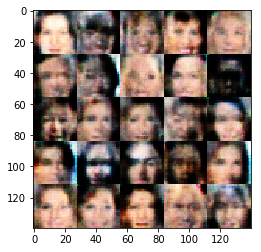

Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 1.1646
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.7481... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 1.0774
Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.6729


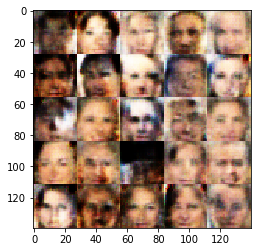

Epoch 1/1... Discriminator Loss: 1.7227... Generator Loss: 0.5165
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 0.5484
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.9389
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.5128... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 1.0750
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.5430


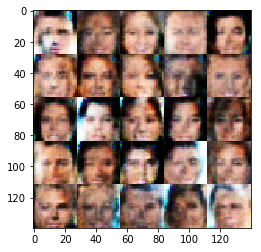

Epoch 1/1... Discriminator Loss: 1.7877... Generator Loss: 0.3913
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.5786... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.5347... Generator Loss: 0.5012
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.8205


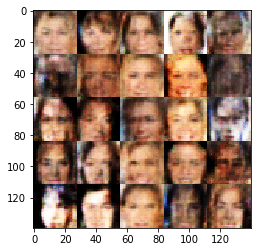

Epoch 1/1... Discriminator Loss: 1.6467... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.5376... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 1.6250... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.9714
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.8524


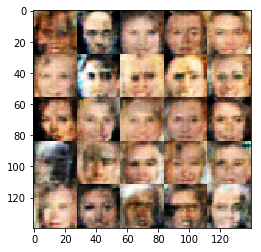

Epoch 1/1... Discriminator Loss: 1.5608... Generator Loss: 0.5386
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 1.5909... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.7163


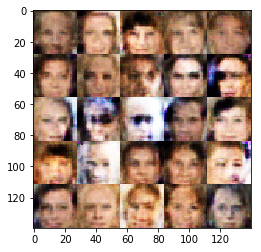

Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.5729... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.6264


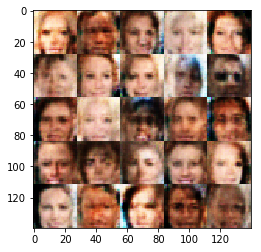

Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 1.5196... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.8201


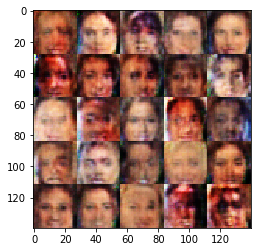

Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.5485... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.6369... Generator Loss: 0.6386


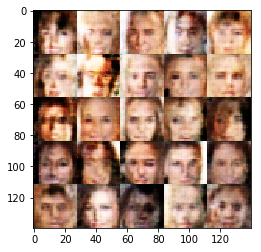

Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7520


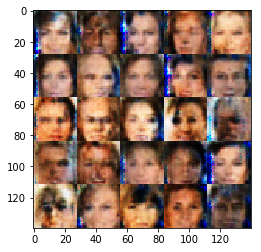

Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.7912


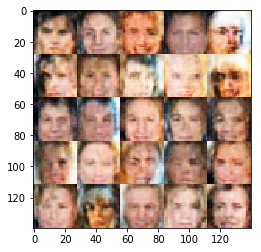

Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.5384... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7448


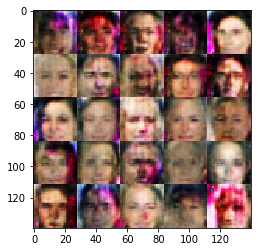

Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.6147... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.8119


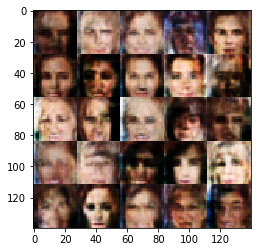

Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.7073


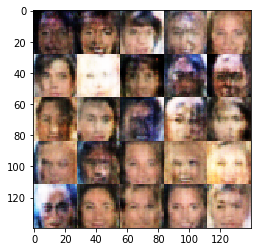

Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.6498


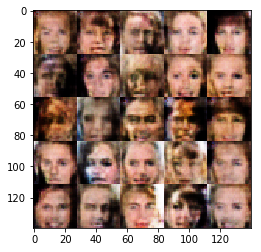

Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.8370
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.5324... Generator Loss: 0.7705


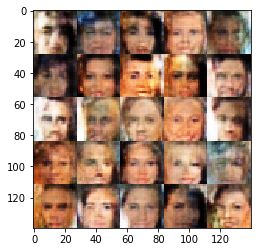

Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.6052... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7419


KeyboardInterrupt: 

In [51]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.